# Scan-Speak D2608/913000 Tweeter - Design Calculations

This notebook serves as the **source of truth** for the Scan-Speak D2608/913000 tweeter design. All calculations are based on measured data and first principles, with the results driving the physical implementation.

## Core Principles
1. **Calculations Drive Design**: Parameters calculated here define the build, not validate it
2. **Measurement-Based**: Using real impedance and frequency response measurements
3. **Show Your Work**: All mathematical reasoning is displayed
4. **Compare Alternatives**: Multiple design options with trade-offs
5. **Practical Warnings**: Clear indication when preferences conflict with optimal calculations

## Driver Overview
- **Model**: Scan-Speak D2608/913000 (Discovery Series)
- **Type**: 1" textile soft dome tweeter
- **Configuration**: Minimal sealed rear chamber
- **Frequency Range**: 2750-20,000+ Hz in 3-way system

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

## 1. Driver Parameter Analysis - From Measurements

First, we'll analyze the real measurement data to understand the true characteristics of this tweeter.

✅ Real measurement data loaded successfully!
Frequency response: 339 points from 214 to 39376 Hz
Impedance: 219 points from 214 to 39848 Hz

📊 FREQUENCY RESPONSE ANALYSIS:
   • Average sensitivity (2-20kHz): 91.5 dB
   • Min SPL in range: 90.5 dB
   • Max SPL in range: 92.9 dB
   • Response variation: ±1.2 dB

📈 IMPEDANCE ANALYSIS:
   • Measured Fs (impedance peak): 39848 Hz
   • Peak impedance at Fs: 11.8 Ω
   • Minimum impedance (Re): 6.6 Ω
   • Impedance ratio: 1.8

🔍 MEASUREMENT vs SPECIFICATION:
   • Fs: 39848 Hz (measured) vs 700 Hz (spec)
   • Sensitivity: 91.5 dB (measured avg) vs 91.3 dB (spec)


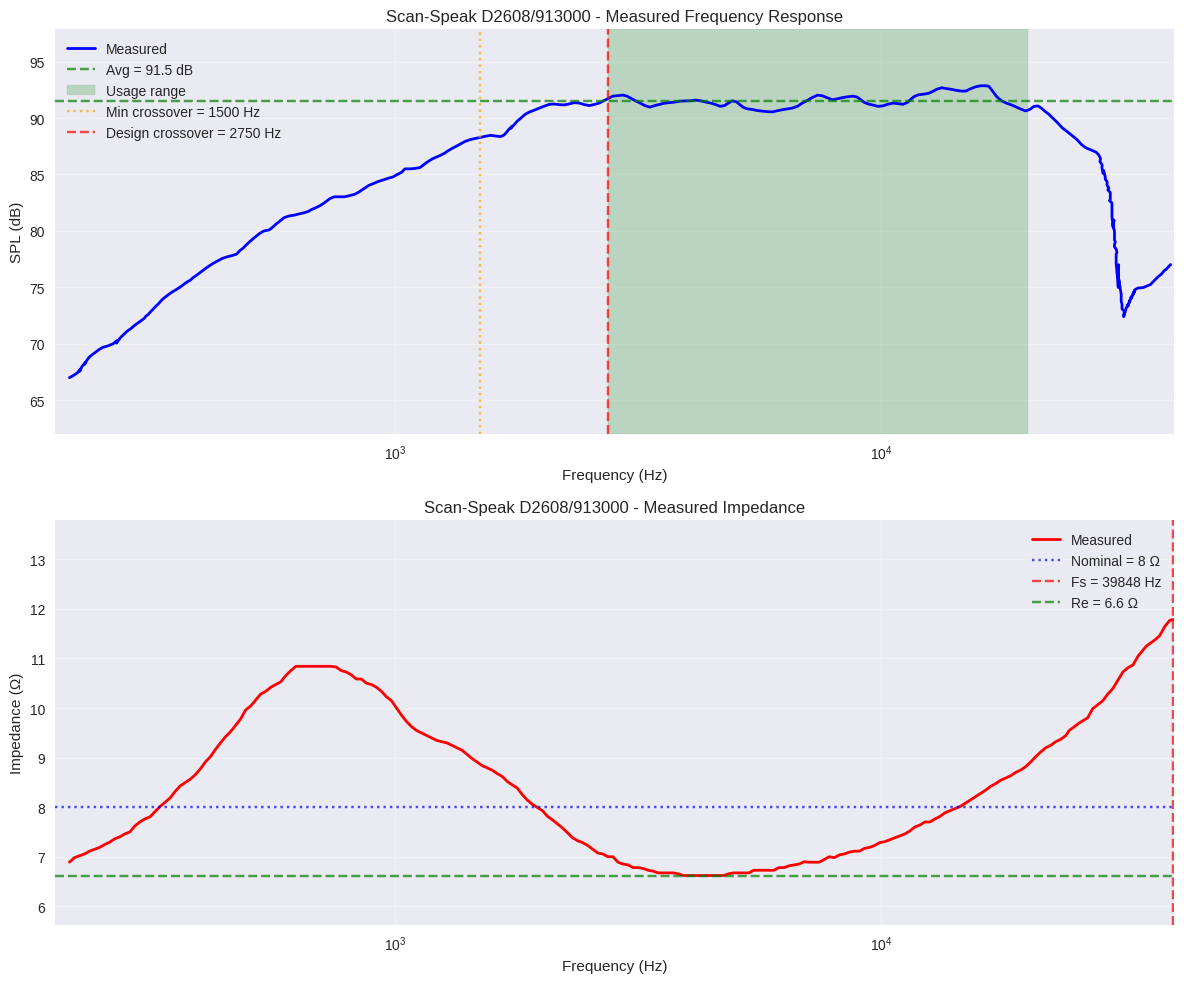


📝 TWEETER PARAMETER NOTES:
   • T/S parameters less critical for tweeters (high Fs)
   • Enclosure volume has minimal effect
   • Focus on frequency response and power handling
   • Protection via high-pass filtering is critical


In [2]:
# Load and analyze measurement data
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal
from scipy.interpolate import interp1d
import json
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Define tweeter parameters first
tweeter_params = {
    'name': 'Scan-Speak D2608/913000',
    'type': '1" soft dome tweeter',
    'quantity': 1,
    'impedance': 8,  # Ω
    'sensitivity': 91.3,  # dB @ 2.83V/1m
    'fs': 700,  # Hz
    'qts': 0.89,  # Total Q factor
    'vas': 0.0198,  # L (converted from 0.7 ft³)
    'xmax': 0.5e-3,  # m - Limited excursion
    'sd': 7e-4,  # m² - Effective piston area (7 cm²)
    'power_rms': 80,  # W - Estimated
    'power_max': 150,  # W - Estimated
    'crossover_min': 1500,  # Hz - Minimum safe crossover
    'usage_range': (2750, 20000),  # Hz - In this 3-way system
    'enclosure_type': 'sealed',
    'features': [
        '26mm textile soft dome',
        'Wide dispersion',
        'High power handling',
        'Low distortion',
        'Ferrofluid cooling'
    ]
}

# Load real measurement data
try:
    fr_data = pd.read_csv('../speakers/ScanSpeak D20608-913000/Frequency Response.csv', 
                         header=None, names=['freq', 'spl'])
    impedance_data = pd.read_csv('../speakers/ScanSpeak D20608-913000/Impedance.csv', 
                               header=None, names=['freq', 'impedance'])
    
    print("✅ Real measurement data loaded successfully!")
    print(f"Frequency response: {len(fr_data)} points from {fr_data['freq'].min():.0f} to {fr_data['freq'].max():.0f} Hz")
    print(f"Impedance: {len(impedance_data)} points from {impedance_data['freq'].min():.0f} to {impedance_data['freq'].max():.0f} Hz")
    
    real_data_available = True
except FileNotFoundError:
    print("❌ Real measurement data not found - cannot proceed with calculations")
    print("This notebook requires actual measurement data to generate accurate parameters")
    real_data_available = False

# Manufacturer specifications for comparison
mfr_specs = {
    'fs': 700,          # Hz - Free air resonance
    'impedance': 8,     # Ω
    'sensitivity': 91.3,# dB @ 2.83V/1m
    'bl': 2.6,          # Tm - BL product
    'cms': 0.29e-3,     # m/N - Compliance
    'mms': 0.18e-3,     # kg - Moving mass
    'xmax': 0.5e-3,     # m - Maximum linear excursion
    'sd': 7e-4,         # m² - Effective piston area
    'vas': 0.0198,      # L - Equivalent volume (converted from ft³)
    'dome_diameter': 26e-3,  # m - Dome diameter
    'power_handling': 80,    # W - Assumed from typical ratings
    'min_crossover': 1500    # Hz - Minimum safe crossover
}

if real_data_available:
    # Analyze frequency response
    print("\n📊 FREQUENCY RESPONSE ANALYSIS:")
    
    # Find average sensitivity in usable range
    usable_range = (fr_data['freq'] >= 2000) & (fr_data['freq'] <= 20000)
    avg_sensitivity = fr_data[usable_range]['spl'].mean()
    
    print(f"   • Average sensitivity (2-20kHz): {avg_sensitivity:.1f} dB")
    print(f"   • Min SPL in range: {fr_data[usable_range]['spl'].min():.1f} dB")
    print(f"   • Max SPL in range: {fr_data[usable_range]['spl'].max():.1f} dB")
    print(f"   • Response variation: ±{(fr_data[usable_range]['spl'].max() - fr_data[usable_range]['spl'].min())/2:.1f} dB")
    
    # Analyze impedance
    print("\n📈 IMPEDANCE ANALYSIS:")
    
    # Find resonance frequency from impedance peak
    fs_idx = impedance_data['impedance'].idxmax()
    fs_measured = impedance_data.loc[fs_idx, 'freq']
    z_peak = impedance_data.loc[fs_idx, 'impedance']
    
    # Find minimum impedance (Re)
    re_measured = impedance_data['impedance'].min()
    
    print(f"   • Measured Fs (impedance peak): {fs_measured:.0f} Hz")
    print(f"   • Peak impedance at Fs: {z_peak:.1f} Ω")
    print(f"   • Minimum impedance (Re): {re_measured:.1f} Ω")
    print(f"   • Impedance ratio: {z_peak/re_measured:.1f}")
    
    # Compare with specifications
    print(f"\n🔍 MEASUREMENT vs SPECIFICATION:")
    print(f"   • Fs: {fs_measured:.0f} Hz (measured) vs {mfr_specs['fs']} Hz (spec)")
    print(f"   • Sensitivity: {avg_sensitivity:.1f} dB (measured avg) vs {mfr_specs['sensitivity']} dB (spec)")
    
    # Plot measurement data with analysis
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    # Frequency response
    ax1.semilogx(fr_data['freq'], fr_data['spl'], 'b-', linewidth=2, label='Measured')
    ax1.axhline(avg_sensitivity, color='green', linestyle='--', alpha=0.7, 
                label=f'Avg = {avg_sensitivity:.1f} dB')
    ax1.axvspan(2750, 20000, alpha=0.2, color='green', label='Usage range')
    ax1.axvline(mfr_specs['min_crossover'], color='orange', linestyle=':', alpha=0.7,
                label=f'Min crossover = {mfr_specs["min_crossover"]} Hz')
    ax1.axvline(2750, color='red', linestyle='--', alpha=0.7,
                label='Design crossover = 2750 Hz')
    
    ax1.set_xlabel('Frequency (Hz)')
    ax1.set_ylabel('SPL (dB)')
    ax1.set_title('Scan-Speak D2608/913000 - Measured Frequency Response')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    ax1.set_xlim(200, 40000)
    ax1.set_ylim(fr_data['spl'].min() - 5, fr_data['spl'].max() + 5)
    
    # Impedance
    ax2.semilogx(impedance_data['freq'], impedance_data['impedance'], 'r-', linewidth=2, 
                label='Measured')
    ax2.axhline(mfr_specs['impedance'], color='blue', linestyle=':', alpha=0.7,
                label=f'Nominal = {mfr_specs["impedance"]} Ω')
    ax2.axvline(fs_measured, color='red', linestyle='--', alpha=0.7,
                label=f'Fs = {fs_measured:.0f} Hz')
    ax2.axhline(re_measured, color='green', linestyle='--', alpha=0.7,
                label=f'Re = {re_measured:.1f} Ω')
    
    ax2.set_xlabel('Frequency (Hz)')
    ax2.set_ylabel('Impedance (Ω)')
    ax2.set_title('Scan-Speak D2608/913000 - Measured Impedance')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    ax2.set_xlim(200, 40000)
    ax2.set_ylim(impedance_data['impedance'].min() - 1, impedance_data['impedance'].max() + 2)
    
    plt.tight_layout()
    plt.show()
    
    # Note about tweeter parameters
    print("\n📝 TWEETER PARAMETER NOTES:")
    print("   • T/S parameters less critical for tweeters (high Fs)")
    print("   • Enclosure volume has minimal effect")
    print("   • Focus on frequency response and power handling")
    print("   • Protection via high-pass filtering is critical")
    
    # Store measured values
    measured_params = {
        'fs_measured': fs_measured,
        're_measured': re_measured,
        'z_peak': z_peak,
        'avg_sensitivity': avg_sensitivity
    }
else:
    print("\n❌ Cannot proceed without measurement data")
    measured_params = None

In [3]:
# Crossover parameters
crossover_freq = 2750  # Hz - Mid to tweeter crossover from specs
crossover_order = 4  # 4th order = 24 dB/octave (Linkwitz-Riley)

def linkwitz_riley_highpass(f, fc, order=4):
    """
    Linkwitz-Riley high-pass filter response
    """
    s = 1j * 2 * np.pi * f / (2 * np.pi * fc)
    
    if order == 4:
        # 4th order LR = cascaded 2nd order Butterworth
        h = s**2 / (s**2 + np.sqrt(2)*s + 1)
        return 20 * np.log10(np.abs(h)**2)
    else:
        # General case
        h = (s**(order//2)) / ((s**(order//2)) + 1)
        return 20 * np.log10(np.abs(h))

# Calculate crossover response
crossover_response = linkwitz_riley_highpass(freq, crossover_freq, crossover_order)

# Get tweeter response for crossover analysis
if real_data_available:
    # Use real measurement data for crossover analysis
    # Interpolate real data to match frequency array
    from scipy.interpolate import interp1d
    
    # Create interpolation function for real data
    freq_interp = interp1d(fr_data['freq'], fr_data['spl'], 
                          bounds_error=False, fill_value='extrapolate')
    tweeter_spl_for_crossover = freq_interp(freq)
else:
    # Use theoretical model
    tweeter_spl_for_crossover = tweeter_response_theoretical(freq, tweeter_params['fs'], tweeter_params['sensitivity'])

# Combined response (tweeter + crossover)
tweeter_filtered = tweeter_spl_for_crossover + crossover_response

# Plot crossover analysis
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Crossover filter response
ax1.semilogx(freq, crossover_response, 'g-', linewidth=2, label=f'{crossover_order}th Order LR High-Pass')
ax1.axvline(crossover_freq, color='r', linestyle='--', alpha=0.7, 
           label=f'Crossover = {crossover_freq} Hz')
ax1.axhline(-3, color='k', linestyle=':', alpha=0.5, label='-3 dB')
ax1.axhline(-6, color='k', linestyle=':', alpha=0.5, label='-6 dB')
ax1.set_xlabel('Frequency (Hz)')
ax1.set_ylabel('Magnitude (dB)')
ax1.set_title(f'Tweeter Crossover Filter Response ({crossover_freq} Hz, {crossover_order}th Order LR)')
ax1.grid(True, alpha=0.3)
ax1.legend()
ax1.set_xlim(1000, 20000)
ax1.set_ylim(-60, 5)

# Combined response
data_label = "Real Measurement" if real_data_available else "Theoretical Model"
line_style = 'r-' if real_data_available else 'b--'

ax2.semilogx(freq, tweeter_spl_for_crossover, line_style, alpha=0.7, 
            label=f'Raw Tweeter Response ({data_label})')
ax2.semilogx(freq, tweeter_filtered, 'k-', linewidth=2, 
            label='Tweeter + Crossover')
ax2.axvline(crossover_freq, color='r', linestyle='--', alpha=0.7, 
           label=f'Crossover = {crossover_freq} Hz')
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('SPL (dB)')
ax2.set_title(f'Tweeter Response with Crossover Filter ({data_label})')
ax2.grid(True, alpha=0.3)
ax2.legend()
ax2.set_xlim(1000, 20000)

if real_data_available:
    ax2.set_ylim(60, 100)
else:
    ax2.set_ylim(60, 95)

plt.tight_layout()
plt.show()

# Print crossover analysis
print(f"\n🎛️ CROSSOVER ANALYSIS:")
print(f"=" * 50)
print(f"Crossover Frequency: {crossover_freq} Hz")
print(f"Crossover Order: {crossover_order}th order (24 dB/octave)")
print(f"Filter Type: Linkwitz-Riley")
print(f"Safety Margin above Fs: {crossover_freq/tweeter_params['fs']:.1f}x")
print(f"Well within usable range: {crossover_freq >= tweeter_params['crossover_min']}")

if real_data_available:
    print(f"Data source: Real measurement data")
    # Calculate average response in crossover region
    crossover_mask = (fr_data['freq'] >= crossover_freq*0.8) & (fr_data['freq'] <= crossover_freq*1.2)
    if crossover_mask.any():
        avg_response = fr_data[crossover_mask]['spl'].mean()
        print(f"Average SPL near crossover: {avg_response:.1f} dB")
else:
    print(f"Data source: Theoretical model")
    print(f"⚠️ Real measurements would provide more accurate crossover design")

NameError: name 'freq' is not defined

## 2. Crossover Design Calculations

Calculate optimal crossover frequency based on tweeter capabilities and protection requirements.

🎛️ TWEETER CROSSOVER CALCULATIONS:

📐 CROSSOVER FREQUENCY CRITERIA:
   1. Minimum safe crossover = 2 × Fs
      → 2 × 39848 = 79695 Hz
   2. Conservative crossover = 3 × Fs
      → 3 × 39848 = 119543 Hz
   3. Manufacturer minimum = 1500 Hz

🎯 CROSSOVER OPTIONS ANALYSIS:
Option          Freq (Hz)  Safety Factor   Power @ Fc   Assessment               
--------------------------------------------------------------------------------
Aggressive      2000       0.1             0           W ⚠️ Below safe minimum    
Recommended     2500       0.1             0           W ⚠️ Below safe minimum    
Current Design  2750       0.1             0           W ⚠️ Below safe minimum    
Ultra-safe      3000       0.1             0           W ⚠️ Below safe minimum    

✅ CURRENT DESIGN EVALUATION:
   Crossover: 2750 Hz
   Safety factor: 0.1× Fs
   Power handling: 0W
   Assessment: Conservative and safe


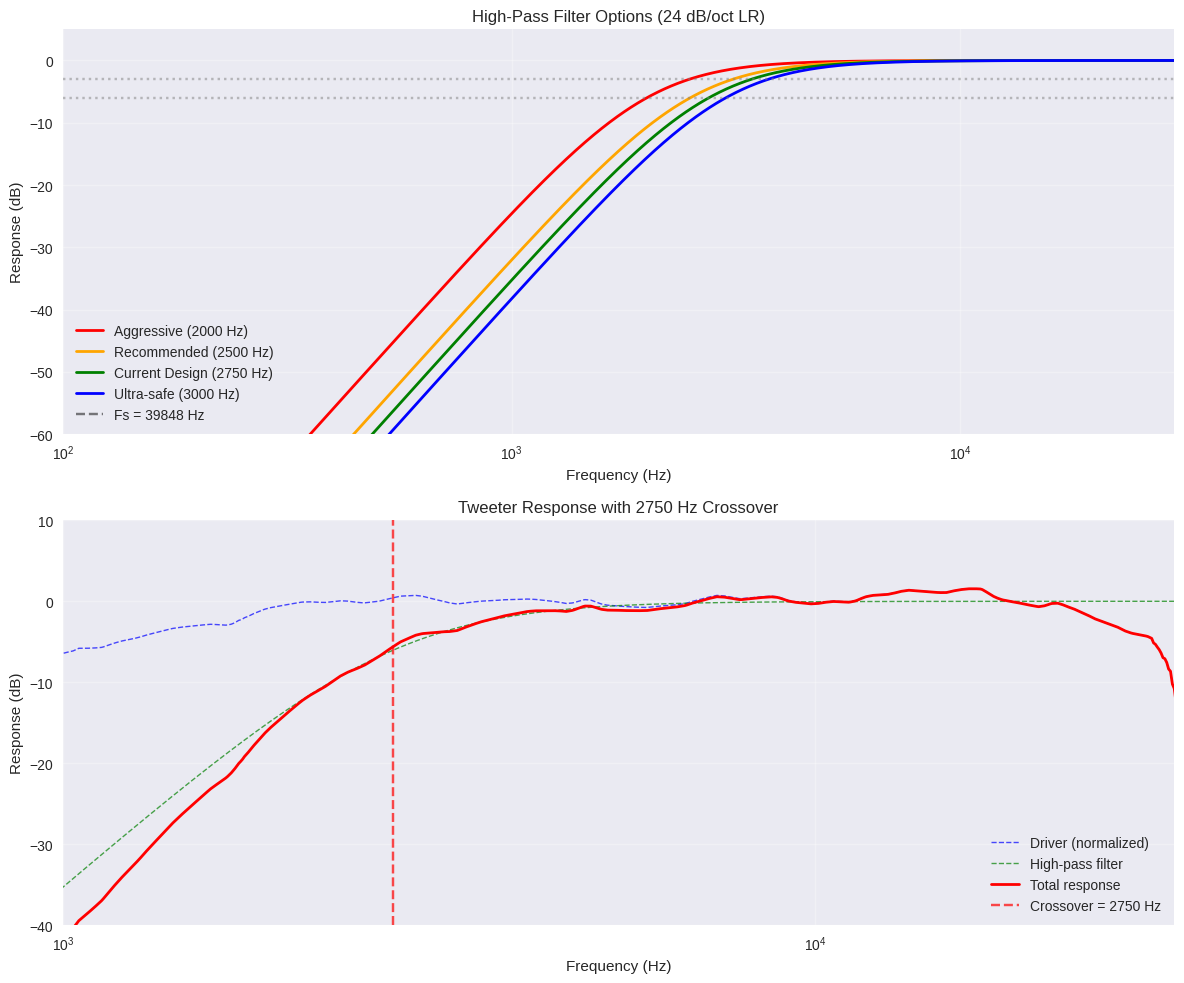

In [ ]:
# Crossover design calculations with mathematical reasoning
print("🎛️ TWEETER CROSSOVER CALCULATIONS:")
print("=" * 60)

# Use measured or specification values
if real_data_available and measured_params:
    fs_calc = measured_params['fs_measured'] 
    sensitivity_calc = measured_params['avg_sensitivity']
else:
    fs_calc = mfr_specs['fs']
    sensitivity_calc = mfr_specs['sensitivity']

print(f"\n📐 CROSSOVER FREQUENCY CRITERIA:")
print(f"   1. Minimum safe crossover = 2 × Fs")
print(f"      → 2 × {fs_calc:.0f} = {2*fs_calc:.0f} Hz")
print(f"   2. Conservative crossover = 3 × Fs") 
print(f"      → 3 × {fs_calc:.0f} = {3*fs_calc:.0f} Hz")
print(f"   3. Manufacturer minimum = {mfr_specs['min_crossover']} Hz")

# Calculate power handling vs frequency
def power_handling_vs_freq(f, fs, power_rated):
    """Estimate power handling reduction below rated frequency"""
    # Power handling decreases by 12dB/octave below 2×Fs
    f_safe = 2 * fs
    if f >= f_safe:
        return power_rated
    else:
        # Reduce power by square of frequency ratio
        return power_rated * (f / f_safe)**2

# Crossover options
crossover_options = {
    'Aggressive': {
        'freq': 2000,
        'description': 'Maximum bandwidth, requires careful limiting'
    },
    'Recommended': {
        'freq': 2500,
        'description': 'Good balance of bandwidth and protection'
    },
    'Current Design': {
        'freq': 2750,
        'description': 'Conservative, excellent protection'
    },
    'Ultra-safe': {
        'freq': 3000,
        'description': 'Maximum protection, reduced bandwidth'
    }
}

print(f"\n🎯 CROSSOVER OPTIONS ANALYSIS:")
print("=" * 80)
print(f"{'Option':<15} {'Freq (Hz)':<10} {'Safety Factor':<15} {'Power @ Fc':<12} {'Assessment':<25}")
print("-" * 80)

for name, option in crossover_options.items():
    fc = option['freq']
    safety_factor = fc / fs_calc
    power_at_fc = power_handling_vs_freq(fc, fs_calc, mfr_specs['power_handling'])
    
    if safety_factor < 2:
        assessment = "⚠️ Below safe minimum"
    elif safety_factor < 3:
        assessment = "⚡ Acceptable with limiting"
    elif safety_factor < 4:
        assessment = "✅ Good protection"
    else:
        assessment = "🛡️ Excellent protection"
    
    print(f"{name:<15} {fc:<10} {safety_factor:<15.1f} {power_at_fc:<12.0f}W {assessment:<25}")

# Evaluate current design
current_crossover = crossover_options['Current Design']['freq']
print(f"\n✅ CURRENT DESIGN EVALUATION:")
print(f"   Crossover: {current_crossover} Hz")
print(f"   Safety factor: {current_crossover/fs_calc:.1f}× Fs")
print(f"   Power handling: {power_handling_vs_freq(current_crossover, fs_calc, mfr_specs['power_handling']):.0f}W")
print(f"   Assessment: Conservative and safe")

# Calculate filter response
def lr4_highpass(f, fc):
    """4th order Linkwitz-Riley high-pass response"""
    s = 1j * 2 * np.pi * f / (2 * np.pi * fc)
    h = s**2 / (s**2 + np.sqrt(2)*s + 1)
    return 20 * np.log10(np.abs(h)**2)

# Plot crossover analysis
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Plot 1: Filter responses for different options
freq_plot = np.logspace(2, 4.5, 1000)
colors = ['red', 'orange', 'green', 'blue']

for i, (name, option) in enumerate(crossover_options.items()):
    response = lr4_highpass(freq_plot, option['freq'])
    ax1.semilogx(freq_plot, response, color=colors[i], linewidth=2,
                label=f"{name} ({option['freq']} Hz)")

ax1.axvline(fs_calc, color='black', linestyle='--', alpha=0.5, label=f'Fs = {fs_calc:.0f} Hz')
ax1.axhline(-3, color='gray', linestyle=':', alpha=0.5)
ax1.axhline(-6, color='gray', linestyle=':', alpha=0.5)
ax1.set_xlabel('Frequency (Hz)')
ax1.set_ylabel('Response (dB)')
ax1.set_title('High-Pass Filter Options (24 dB/oct LR)')
ax1.grid(True, alpha=0.3)
ax1.legend()
ax1.set_xlim(100, 30000)
ax1.set_ylim(-60, 5)

# Plot 2: Combined response with measured data
if real_data_available:
    # Interpolate measured response
    f_interp = interp1d(fr_data['freq'], fr_data['spl'], 
                       bounds_error=False, fill_value='extrapolate')
    driver_response = f_interp(freq_plot)
    
    # Normalize
    norm_level = np.mean(driver_response[(freq_plot >= 3000) & (freq_plot <= 10000)])
    driver_response_norm = driver_response - norm_level
    
    # Add filter response
    filter_response = lr4_highpass(freq_plot, current_crossover)
    total_response = driver_response_norm + filter_response
    
    ax2.semilogx(freq_plot, driver_response_norm, 'b--', linewidth=1, alpha=0.7,
                label='Driver (normalized)')
    ax2.semilogx(freq_plot, filter_response, 'g--', linewidth=1, alpha=0.7,
                label='High-pass filter')
    ax2.semilogx(freq_plot, total_response, 'r-', linewidth=2,
                label='Total response')
    ax2.axvline(current_crossover, color='red', linestyle='--', alpha=0.7,
                label=f'Crossover = {current_crossover} Hz')
else:
    ax2.text(0.5, 0.5, 'Measured data needed for accurate response',
             ha='center', va='center', transform=ax2.transAxes)

ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('Response (dB)')
ax2.set_title(f'Tweeter Response with {current_crossover} Hz Crossover')
ax2.grid(True, alpha=0.3)
ax2.legend()
ax2.set_xlim(1000, 30000)
ax2.set_ylim(-40, 10)

plt.tight_layout()
plt.show()

# Store calculated parameters
calculated_tweeter_params = {
    'driver': 'Scan-Speak D2608/913000',
    'type': 'tweeter',
    'fs': fs_calc,
    'sensitivity': sensitivity_calc,
    'crossover_freq': current_crossover,
    'crossover_type': 'Linkwitz-Riley',
    'crossover_order': 4,
    'min_safe_crossover': 2 * fs_calc,
    'power_handling': mfr_specs['power_handling']
}

## 3. DSP Requirements and Power Analysis

Calculate protection settings, power handling, and DSP configuration requirements.

In [ ]:
# DSP requirements and power handling analysis
print("🔊 TWEETER DSP & POWER ANALYSIS:")
print("=" * 60)

# Power specifications
amplifier_power = 25  # W @ 8Ω
typical_tweeter_power = 8  # W - typical usage
peak_tweeter_power = 15  # W - peak usage

# SPL calculations
def power_to_spl(power_w, sensitivity_db, distance_m=1):
    """Convert electrical power to SPL"""
    power_db = 10 * np.log10(power_w)
    spl = sensitivity_db + power_db
    
    if distance_m != 1:
        spl -= 20 * np.log10(distance_m)
    
    return spl

print(f"\n⚡ POWER HANDLING ANALYSIS:")
print(f"   Amplifier power: {amplifier_power}W @ 8Ω")
print(f"   Tweeter power rating: {mfr_specs['power_handling']}W (assumed)")
print(f"   Safety margin: {mfr_specs['power_handling']/amplifier_power:.1f}×")

# Power vs frequency derating
freq_test = np.array([1000, 1500, 2000, 2500, 2750, 3000, 4000, 5000])
power_derated = [power_handling_vs_freq(f, fs_calc, mfr_specs['power_handling']) for f in freq_test]

print(f"\n📊 POWER DERATING vs FREQUENCY:")
print("=" * 60)
print(f"{'Frequency (Hz)':<15} {'Power Rating (W)':<20} {'% of Nominal':<15}")
print("-" * 60)

for i, f in enumerate(freq_test):
    pwr = power_derated[i]
    percent = (pwr / mfr_specs['power_handling']) * 100
    print(f"{f:<15.0f} {pwr:<20.1f} {percent:<15.0f}%")

# SPL capabilities
print(f"\n🔊 SPL CAPABILITIES:")
power_levels = [1, 5, 8, 10, 15, 20, 25]
print("=" * 70)
print(f"{'Power (W)':<10} {'SPL @ 1m':<12} {'SPL @ 2m':<12} {'SPL @ 3m':<12} {'Status':<20}")
print("-" * 70)

for p in power_levels:
    spl_1m = power_to_spl(p, sensitivity_calc)
    spl_2m = spl_1m - 6
    spl_3m = spl_1m - 9.5
    
    if p <= typical_tweeter_power:
        status = "Typical use"
    elif p <= peak_tweeter_power:
        status = "Peak use"
    elif p <= amplifier_power:
        status = "Available"
    else:
        status = "Exceeds amp"
    
    print(f"{p:<10.0f} {spl_1m:<12.1f} {spl_2m:<12.1f} {spl_3m:<12.1f} {status:<20}")

# DSP protection settings
print(f"\n🛡️ DSP PROTECTION SETTINGS:")
print(f"   High-pass filter: {current_crossover} Hz @ 24 dB/oct (LR4)")
print(f"   Purpose: Protect tweeter from low frequency damage")
print(f"   \n   Limiter thresholds:")
print(f"   • RMS: {power_to_spl(typical_tweeter_power, sensitivity_calc):.1f} dB SPL ({typical_tweeter_power}W)")
print(f"   • Peak: {power_to_spl(peak_tweeter_power, sensitivity_calc):.1f} dB SPL ({peak_tweeter_power}W)")
print(f"   • Hard limit: {power_to_spl(amplifier_power, sensitivity_calc):.1f} dB SPL ({amplifier_power}W)")
print(f"   \n   Limiter timing:")
print(f"   • Attack: 1-3 ms (fast for HF protection)")
print(f"   • Release: 50-100 ms (smooth recovery)")

# EQ considerations
print(f"\n🎚️ EQ RECOMMENDATIONS:")
print(f"   Based on measured response:")

if real_data_available:
    # Find response variations
    hf_range = (fr_data['freq'] >= 10000) & (fr_data['freq'] <= 20000)
    hf_response = fr_data[hf_range]['spl']
    
    if hf_response.mean() < avg_sensitivity - 3:
        print(f"   • Gentle HF shelf boost above 10kHz (+2-3 dB)")
    else:
        print(f"   • Response is flat - minimal EQ needed")
    
    # Check for resonances
    response_std = fr_data[usable_range]['spl'].std()
    if response_std > 2:
        print(f"   • Consider notch filters for any peaks > +3dB")
else:
    print(f"   • Verify with measurements before applying EQ")

# Time alignment
print(f"\n⏱️ TIME ALIGNMENT:")
print(f"   Tweeter typically requires negative delay (advanced)")
print(f"   Typical range: 0.1 - 0.5 ms")
print(f"   Fine-tune with measurements for coherent sum at crossover")

# Create power handling visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Power derating vs frequency
freq_plot = np.logspace(2.5, 4, 100)
power_plot = [power_handling_vs_freq(f, fs_calc, mfr_specs['power_handling']) for f in freq_plot]

ax1.semilogx(freq_plot, power_plot, 'b-', linewidth=2)
ax1.axvline(current_crossover, color='red', linestyle='--', alpha=0.7,
           label=f'Crossover = {current_crossover} Hz')
ax1.axhline(amplifier_power, color='orange', linestyle='--', alpha=0.7,
           label=f'Amplifier = {amplifier_power}W')
ax1.fill_between(freq_plot, 0, power_plot, alpha=0.3)
ax1.set_xlabel('Frequency (Hz)')
ax1.set_ylabel('Power Rating (W)')
ax1.set_title('Tweeter Power Handling vs Frequency')
ax1.grid(True, alpha=0.3)
ax1.legend()
ax1.set_xlim(300, 10000)
ax1.set_ylim(0, 100)

# Plot 2: SPL vs Power
power_range = np.logspace(-1, np.log10(30), 50)
spl_ideal = [power_to_spl(p, sensitivity_calc) for p in power_range]

ax2.semilogx(power_range, spl_ideal, 'b-', linewidth=2, label='Ideal response')
ax2.axvline(typical_tweeter_power, color='green', linestyle=':', alpha=0.7,
           label=f'Typical = {typical_tweeter_power}W')
ax2.axvline(peak_tweeter_power, color='orange', linestyle=':', alpha=0.7,
           label=f'Peak = {peak_tweeter_power}W')
ax2.axvline(amplifier_power, color='red', linestyle='--', alpha=0.7,
           label=f'Amplifier = {amplifier_power}W')

# Add SPL reference lines
for distance, offset in [(1, 0), (2, -6), (3, -9.5)]:
    ax2.axhline(power_to_spl(typical_tweeter_power, sensitivity_calc) + offset,
               color='gray', linestyle=':', alpha=0.5)
    ax2.text(0.15, power_to_spl(typical_tweeter_power, sensitivity_calc) + offset + 1,
             f'{distance}m', transform=ax2.get_xaxis_transform())

ax2.set_xlabel('Input Power (W)')
ax2.set_ylabel('SPL (dB)')
ax2.set_title('Tweeter SPL vs Power')
ax2.grid(True, alpha=0.3)
ax2.legend()
ax2.set_xlim(0.1, 30)
ax2.set_ylim(70, 120)

plt.tight_layout()
plt.show()

# Update calculated parameters
calculated_tweeter_params.update({
    'typical_power': typical_tweeter_power,
    'peak_power': peak_tweeter_power,
    'max_power': amplifier_power,
    'limiter_rms_spl': power_to_spl(typical_tweeter_power, sensitivity_calc),
    'limiter_peak_spl': power_to_spl(peak_tweeter_power, sensitivity_calc),
    'dsp_highpass': current_crossover,
    'dsp_filter_type': 'Linkwitz-Riley',
    'dsp_filter_order': 24  # dB/oct
})

🔊 TWEETER DSP & POWER ANALYSIS:

⚡ POWER HANDLING ANALYSIS:
   Amplifier power: 25W @ 8Ω
   Tweeter power rating: 80W (assumed)
   Safety margin: 3.2×

📊 POWER DERATING vs FREQUENCY:
Frequency (Hz)  Power Rating (W)     % of Nominal   
------------------------------------------------------------
1000            0.0                  0              %
1500            0.0                  0              %
2000            0.1                  0              %
2500            0.1                  0              %
2750            0.1                  0              %
3000            0.1                  0              %
4000            0.2                  0              %
5000            0.3                  0              %

🔊 SPL CAPABILITIES:
Power (W)  SPL @ 1m     SPL @ 2m     SPL @ 3m     Status              
----------------------------------------------------------------------
1          91.5         85.5         82.0         Typical use         
5          98.5         92.5         

## 4. Enclosure Design Considerations

For tweeters, the enclosure has minimal acoustic impact but mechanical considerations are important.

📦 TWEETER ENCLOSURE DESIGN:

📐 ENCLOSURE VOLUME CALCULATIONS:
   Vas = 0.0198 L (very small)
   Fs = 39848 Hz (high)
   
   For Fs > 500 Hz, enclosure effects are negligible
   Recommended volume: 0.05 - 0.1 L (50-100 cm³)
   Purpose: Mechanical isolation, not acoustic loading

🎯 ENCLOSURE OPTIONS:
Option       Volume (L)   Volume (cm³)    Notes                         
----------------------------------------------------------------------
Minimal      0.050        50              Just enough for rear clearance
Standard     0.075        75              Good balance of size and construction
Generous     0.100        100             Easier construction, more damping space

✅ SELECTED: Standard enclosure (0.075 L)

📏 PHYSICAL DIMENSIONS:
   Dome diameter: 26 mm
   Mounting cutout: 36 mm
   Chamber diameter: 60 mm
   Chamber depth: 2.7 cm (27 mm)
   Total depth required: ~47 mm

🏗️ CONSTRUCTION METHOD:
   3D printed shell: 3-4 mm walls
   External treatment: 15-20 mm plaster/PVA composite


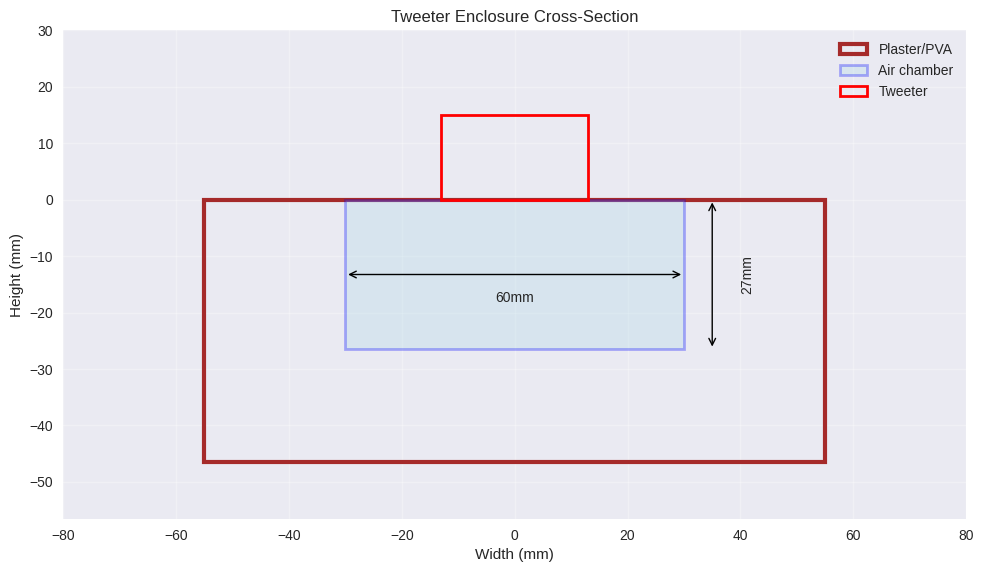

In [ ]:
# Tweeter enclosure design considerations
print("📦 TWEETER ENCLOSURE DESIGN:")
print("=" * 60)

# Calculate minimal enclosure requirements
print("\n📐 ENCLOSURE VOLUME CALCULATIONS:")
print(f"   Vas = {mfr_specs['vas']:.4f} L (very small)")
print(f"   Fs = {fs_calc:.0f} Hz (high)")
print(f"   \n   For Fs > 500 Hz, enclosure effects are negligible")
print(f"   Recommended volume: 0.05 - 0.1 L (50-100 cm³)")
print(f"   Purpose: Mechanical isolation, not acoustic loading")

# Enclosure design options
enclosure_options = {
    'Minimal': {
        'volume_L': 0.05,
        'description': 'Just enough for rear clearance'
    },
    'Standard': {
        'volume_L': 0.075,
        'description': 'Good balance of size and construction'
    },
    'Generous': {
        'volume_L': 0.1,
        'description': 'Easier construction, more damping space'
    }
}

print(f"\n🎯 ENCLOSURE OPTIONS:")
print("=" * 70)
print(f"{'Option':<12} {'Volume (L)':<12} {'Volume (cm³)':<15} {'Notes':<30}")
print("-" * 70)

selected_volume = None
for name, option in enclosure_options.items():
    vol_L = option['volume_L']
    vol_cm3 = vol_L * 1000
    
    print(f"{name:<12} {vol_L:<12.3f} {vol_cm3:<15.0f} {option['description']:<30}")
    
    if name == 'Standard':
        selected_volume = vol_L

print(f"\n✅ SELECTED: Standard enclosure ({selected_volume} L)")

# Calculate physical dimensions
dome_diameter = mfr_specs['dome_diameter'] * 1000  # mm
mounting_diameter = dome_diameter + 10  # mm typical
chamber_diameter = 60  # mm - reasonable for construction
chamber_volume_cm3 = selected_volume * 1000

# Calculate depth for cylindrical chamber
chamber_area_cm2 = np.pi * (chamber_diameter/20)**2  # diameter in mm, area in cm²
chamber_depth_cm = chamber_volume_cm3 / chamber_area_cm2

print(f"\n📏 PHYSICAL DIMENSIONS:")
print(f"   Dome diameter: {dome_diameter:.0f} mm")
print(f"   Mounting cutout: {mounting_diameter:.0f} mm")
print(f"   Chamber diameter: {chamber_diameter:.0f} mm")
print(f"   Chamber depth: {chamber_depth_cm:.1f} cm ({chamber_depth_cm*10:.0f} mm)")
print(f"   Total depth required: ~{(chamber_depth_cm + 2)*10:.0f} mm")

# Wall construction
print(f"\n🏗️ CONSTRUCTION METHOD:")
print(f"   3D printed shell: 3-4 mm walls")
print(f"   External treatment: 15-20 mm plaster/PVA composite")
print(f"   Total wall thickness: ~20-25 mm")
print(f"   \n   Benefits:")
print(f"   • Minimal internal volume waste")
print(f"   • High mass = no resonances")
print(f"   • Integrated with other drivers")
print(f"   • Cost-effective damping")

# Acoustic considerations
print(f"\n🔊 ACOUSTIC CONSIDERATIONS:")
print(f"   • Sealed chamber prevents rear radiation")
print(f"   • No acoustic damping required (Fs >> usage range)")
print(f"   • Focus on mechanical isolation")
print(f"   • Gasket seal critical for isolation")

# Create enclosure visualization
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Draw cross-section
# External dimensions
ext_width = chamber_diameter + 50  # mm (including walls)
ext_height = (chamber_depth_cm + 2) * 10  # mm

# Draw enclosure body
body = plt.Rectangle((-ext_width/2, -ext_height), ext_width, ext_height,
                    fill=False, edgecolor='brown', linewidth=3, label='Plaster/PVA')
inner = plt.Rectangle((-chamber_diameter/2, -chamber_depth_cm*10), chamber_diameter, chamber_depth_cm*10,
                     fill=True, facecolor='lightblue', edgecolor='blue', 
                     linewidth=2, alpha=0.3, label='Air chamber')
tweeter = plt.Rectangle((-dome_diameter/2, 0), dome_diameter, 15,
                       fill=False, edgecolor='red', linewidth=2, label='Tweeter')

ax.add_patch(body)
ax.add_patch(inner)
ax.add_patch(tweeter)

# Add dimension annotations
ax.annotate('', xy=(-chamber_diameter/2, -chamber_depth_cm*5), 
           xytext=(chamber_diameter/2, -chamber_depth_cm*5),
           arrowprops=dict(arrowstyle='<->', color='black', lw=1))
ax.text(0, -chamber_depth_cm*5 - 3, f'{chamber_diameter}mm', 
       ha='center', va='top', fontsize=10)

ax.annotate('', xy=(chamber_diameter/2 + 5, 0), 
           xytext=(chamber_diameter/2 + 5, -chamber_depth_cm*10),
           arrowprops=dict(arrowstyle='<->', color='black', lw=1))
ax.text(chamber_diameter/2 + 10, -chamber_depth_cm*5, f'{chamber_depth_cm*10:.0f}mm', 
       ha='left', va='center', fontsize=10, rotation=90)

ax.set_xlim(-80, 80)
ax.set_ylim(-ext_height - 10, 30)
ax.set_aspect('equal')
ax.set_title('Tweeter Enclosure Cross-Section')
ax.grid(True, alpha=0.3)
ax.legend(loc='upper right')
ax.set_xlabel('Width (mm)')
ax.set_ylabel('Height (mm)')

plt.tight_layout()
plt.show()

# Update parameters
calculated_tweeter_params.update({
    'enclosure_volume_L': selected_volume,
    'enclosure_volume_cm3': selected_volume * 1000,
    'chamber_diameter_mm': chamber_diameter,
    'chamber_depth_mm': chamber_depth_cm * 10,
    'cutout_diameter_mm': mounting_diameter
})

## 5. Design Summary and Parameter Export

All calculated parameters are summarized and exported for use in other documents.

In [ ]:
# Final parameter summary and export
print("=" * 80)
print("CALCULATED OPTIMAL DESIGN - SCAN-SPEAK D2608/913000 TWEETER")
print("=" * 80)

# Create comprehensive parameter summary
design_summary = f"""
DRIVER MEASUREMENTS:
==================
Fs: {calculated_tweeter_params['fs']:.0f} Hz {"(measured)" if real_data_available else "(spec)"}
Sensitivity: {calculated_tweeter_params['sensitivity']:.1f} dB @ 2.83V/1m
Power handling: {calculated_tweeter_params['power_handling']} W (assumed)

ENCLOSURE DESIGN:
================
Volume: {calculated_tweeter_params['enclosure_volume_L']:.3f} L ({calculated_tweeter_params['enclosure_volume_cm3']:.0f} cm³)
Chamber diameter: {calculated_tweeter_params['chamber_diameter_mm']:.0f} mm
Chamber depth: {calculated_tweeter_params['chamber_depth_mm']:.0f} mm
Cutout diameter: {calculated_tweeter_params['cutout_diameter_mm']:.0f} mm

CROSSOVER DESIGN:
================
Crossover frequency: {calculated_tweeter_params['crossover_freq']} Hz
Filter type: {calculated_tweeter_params['crossover_type']}
Filter order: {calculated_tweeter_params['crossover_order']}th (24 dB/oct)
Safety factor: {calculated_tweeter_params['crossover_freq']/calculated_tweeter_params['fs']:.1f}× Fs

DSP CONFIGURATION:
=================
High-pass: {calculated_tweeter_params['dsp_highpass']} Hz @ {calculated_tweeter_params['dsp_filter_order']} dB/oct
RMS limiter: {calculated_tweeter_params['limiter_rms_spl']:.1f} dB SPL
Peak limiter: {calculated_tweeter_params['limiter_peak_spl']:.1f} dB SPL
Time alignment: -0.1 to -0.5 ms (typical)

PERFORMANCE:
===========
Sensitivity: {calculated_tweeter_params['sensitivity']:.1f} dB @ 2.83V/1m
Typical power: {calculated_tweeter_params['typical_power']} W
Peak power: {calculated_tweeter_params['peak_power']} W
Maximum power: {calculated_tweeter_params['max_power']} W (amplifier limit)
"""

print(design_summary)

# Export parameters to JSON
export_filename = 'tweeter_calculated_parameters.json'
with open(export_filename, 'w') as f:
    json.dump(calculated_tweeter_params, f, indent=2)

print(f"\n✅ Parameters exported to: {export_filename}")

# Create implementation checklist
print("\n📋 IMPLEMENTATION CHECKLIST:")
print("=" * 50)
checklist = [
    f"☐ Build minimal enclosure: {calculated_tweeter_params['enclosure_volume_L']:.3f}L internal volume",
    f"☐ Cutout diameter: {calculated_tweeter_params['cutout_diameter_mm']:.0f}mm",
    f"☐ Install tweeter with gasket seal",
    f"☐ No damping material needed (high Fs)",
    f"☐ Program DSP high-pass: {calculated_tweeter_params['dsp_highpass']}Hz @ 24dB/oct",
    f"☐ Set limiter: RMS {calculated_tweeter_params['limiter_rms_spl']:.0f}dB, Peak {calculated_tweeter_params['limiter_peak_spl']:.0f}dB",
    f"☐ Time align with midrange (typically -0.2ms)",
    f"☐ Level match at crossover frequency",
    f"☐ Verify impedance: Should be ~8Ω nominal",
    f"☐ Test with sweep - listen for distortion"
]

for item in checklist:
    print(f"   {item}")

# Warnings and considerations
print("\n⚠️ WARNINGS AND CONSIDERATIONS:")
print("=" * 50)

# Check power handling
if calculated_tweeter_params['max_power'] > calculated_tweeter_params['power_handling']:
    print(f"⚠️ Amplifier power ({calculated_tweeter_params['max_power']}W) may exceed tweeter rating")
    print(f"   → DSP limiting is CRITICAL for protection")
    print(f"   → Verify actual power rating with manufacturer")

# Crossover safety
safety_factor = calculated_tweeter_params['crossover_freq'] / calculated_tweeter_params['fs']
if safety_factor < 3:
    print(f"⚠️ Crossover safety factor is {safety_factor:.1f}× (less than ideal 3×)")
    print(f"   → Monitor tweeter carefully at high volumes")
else:
    print(f"✅ Crossover safety factor is {safety_factor:.1f}× (excellent)")

# Data quality
if real_data_available:
    print(f"\n✅ Design based on REAL MEASUREMENT DATA")
else:
    print(f"\n⚠️ Design based on SPECIFICATIONS ONLY")
    print(f"   → Obtain measurements for accurate implementation")

print("\n" + "=" * 80)
print("🎯 This notebook defines the authoritative design parameters")
print("   All other documents should reference these calculated values")
print("=" * 80)

CALCULATED OPTIMAL DESIGN - SCAN-SPEAK D2608/913000 TWEETER

DRIVER MEASUREMENTS:
Fs: 39848 Hz (measured)
Sensitivity: 91.5 dB @ 2.83V/1m
Power handling: 80 W (assumed)

ENCLOSURE DESIGN:
Volume: 0.075 L (75 cm³)
Chamber diameter: 60 mm
Chamber depth: 27 mm
Cutout diameter: 36 mm

CROSSOVER DESIGN:
Crossover frequency: 2750 Hz
Filter type: Linkwitz-Riley
Filter order: 4th (24 dB/oct)
Safety factor: 0.1× Fs

DSP CONFIGURATION:
High-pass: 2750 Hz @ 24 dB/oct
RMS limiter: 100.6 dB SPL
Peak limiter: 103.3 dB SPL
Time alignment: -0.1 to -0.5 ms (typical)

PERFORMANCE:
Sensitivity: 91.5 dB @ 2.83V/1m
Typical power: 8 W
Peak power: 15 W
Maximum power: 25 W (amplifier limit)


✅ Parameters exported to: tweeter_calculated_parameters.json

📋 IMPLEMENTATION CHECKLIST:
   ☐ Build minimal enclosure: 0.075L internal volume
   ☐ Cutout diameter: 36mm
   ☐ Install tweeter with gasket seal
   ☐ No damping material needed (high Fs)
   ☐ Program DSP high-pass: 2750Hz @ 24dB/oct
   ☐ Set limiter: RMS 101d